In [59]:
import numpy as np
import random
import matplotlib.pyplot as plt
from typing import Tuple


# Parámetros del entorno
MAX_STATE = 10           # Escala de 0 a 10 para C1 y C2
LAMBDA_ARRIVAL_C1 = 2       # Parámetro de la distribución de Poisson para llegadas
LAMBDA_ARRIVAL_C2 = 1       # Parámetro de la distribución de Poisson para llegadas

# Parámetros de Q-Learning
ALPHA = 0.1              # Tasa de aprendizaje
GAMMA = 0.9             # Factor de descuento
EPSILON = 1.0            # Tasa de exploración inicial
EPSILON_MIN = 0.01
EPSILON_DECAY = 0.995
NUM_EPISODES = 10001
STEPS_PER_EPISODE = 50

In [60]:
# Función de recompensa dinámica según el nivel de congestión
def compute_reward(c1, c2):
    # Si C1 está congestionado (mayor a 7) y es el que tiene mayor o igual congestión
    if c1 > 7 and c1 >= c2:
        return -(2 * c1 + c2)
    # Si C2 está congestionado (mayor a 7) y es el que tiene mayor congestión
    elif c2 > 7 and c2 > c1:
        return -(c1 + 2 * c2)
    # Si ambos carriles tienes igual congestión alta/baja
    else:
        return -(c1 + c2)
    

In [84]:
import random
import numpy as np
import gym
from gym import spaces
import matplotlib.pyplot as plt

MAX_STATE = 10

def compute_reward(c1, c2):
    # castiga la congestión y premia el servicio
    return - (c1 + c2)

class TrafficEnv(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self,
                 c1_lambda=4,
                 c2_lambda=1,
                 max_state=MAX_STATE,
                 max_steps=100):
        super().__init__()

        # parámetros
        self.c1_lambda = c1_lambda
        self.c2_lambda = c2_lambda
        self.max_state = max_state
        self.max_steps = max_steps
        self.service_time_C1 = 1
        self.service_time_C2 = 1

        # acciones: Discrete(3), index en self.actions
        # cada tupla es la capacidad de servicio (vehículos/time step)
        self.actions = [
            {'C1_service': 8, 'C2_service': 4},
            {'C1_service': 4, 'C2_service': 8},
            {'C1_service': 5, 'C2_service': 5},
        ]

        # espacios
        # observación = (c1, c2), cada uno en [0..max_state]
        self.observation_space = spaces.Box(
            low=0, high=max_state, shape=(2,), dtype=np.int32
        )
        # acción = 0,1,2
        self.action_space = spaces.Discrete(len(self.actions))

        # estado interno
        self.seed()
        self.reset()

    def seed(self, seed=None):
        random.seed(seed)
        np.random.seed(seed)

    def reset(self):
        # reinicia congestión y contador de pasos
        self.c1 = random.randint(1, 3)
        self.c2 = random.randint(1, 3)
        self.step_count = 0
        return np.array([self.c1, self.c2], dtype=np.int32)

    def step(self, action):
        srv = self.actions[action]
        # 1) Servir C1
        served1 = min(self.c1, srv['C1_service'])
        self.c1 -= served1
        # llegadas DURANTE el servicio de C1 (duración subjetiva 1 unidad)
        arr1_during = np.random.poisson(self.c1_lambda * self.service_time_C1)
        arr2_during = np.random.poisson(self.c2_lambda * self.service_time_C1)
        self.c1 = min(self.c1 + arr1_during, self.max_state)
        self.c2 = min(self.c2 + arr2_during, self.max_state)

        # 2) Servir C2
        served2 = min(self.c2, srv['C2_service'])
        self.c2 -= served2
        # llegadas DURANTE el servicio de C2
        arr1_after = np.random.poisson(self.c1_lambda * self.service_time_C2)
        arr2_after = np.random.poisson(self.c2_lambda * self.service_time_C2)
        self.c1 = min(self.c1 + arr1_after, self.max_state)
        self.c2 = min(self.c2 + arr2_after, self.max_state)

        reward = compute_reward(self.c1, self.c2)
        done = (self.step_count >= self.max_steps)
        return (self.c1, self.c2), reward, done

    def render(self, title=None):
        # reutiliza tu plot() para visualizar estado actual
        size = self.max_state + 2
        H, W = size, size
        mid = size // 2

        # crea matriz base
        grid = np.zeros((H, W), int)
        # carriles verticales (C1) en columnas mid-1, mid
        for r in range(H):
            if r < mid-1 or r > mid:
                grid[r, mid-1] = 1
                grid[r, mid]   = 1
        # carriles horizontales (C2) en filas mid-1, mid
        for c in range(W):
            if c < mid-1 or c > mid:
                grid[mid-1, c] = 2
                grid[mid,   c] = 2
        # intersección
        grid[mid-1:mid+1, mid-1:mid+1] = 3

        plt.figure(figsize=(6,6))
        plt.imshow(grid, cmap='gray', interpolation='nearest')

        # scatter dinámico
        # C1
        coords_c1 = []
        # 5 arriba
        for d in range(1, mid):
            for cc in (mid-1, mid):
                coords_c1.append((mid-1 - d, cc))
        # 5 abajo
        for d in range(1, mid):
            for cc in (mid-1, mid):
                coords_c1.append((mid + d, cc))
        for y,x in coords_c1[:self.c1]:
            plt.scatter(x, y, color='red', s=100)
        # C2
        coords_c2 = []
        # 5 derecha
        for d in range(1, mid):
            for rr in (mid-1, mid):
                coords_c2.append((rr, mid + d))
        # 5 izquierda
        for d in range(1, mid):
            for rr in (mid-1, mid):
                coords_c2.append((rr, mid-1 - d))
        for y,x in coords_c2[:self.c2]:
            plt.scatter(x, y, color='blue', s=100)

        plt.xticks([]); plt.yticks([])
        plt.title(f"Paso {self.step_count} — C1={self.c1}  C2={self.c2}"+title if title else "")
        plt.show()


## Random approach (baseline)

Episode 0: Total reward = -6.14
Episode 500: Total reward = -4.98
Episode 1000: Total reward = -6.08
Episode 1500: Total reward = -6.44
Episode 2000: Total reward = -5.04
Episode 2500: Total reward = -5.72
Episode 3000: Total reward = -5.06
Episode 3500: Total reward = -5.8
Episode 4000: Total reward = -6.46
Episode 4500: Total reward = -6.32
Episode 5000: Total reward = -5.84
Episode 5500: Total reward = -5.66
Episode 6000: Total reward = -5.48
Episode 6500: Total reward = -6.24
Episode 7000: Total reward = -4.9
Episode 7500: Total reward = -5.12
Episode 8000: Total reward = -5.94
Episode 8500: Total reward = -5.74
Episode 9000: Total reward = -5.46
Episode 9500: Total reward = -5.94
Episode 10000: Total reward = -5.28


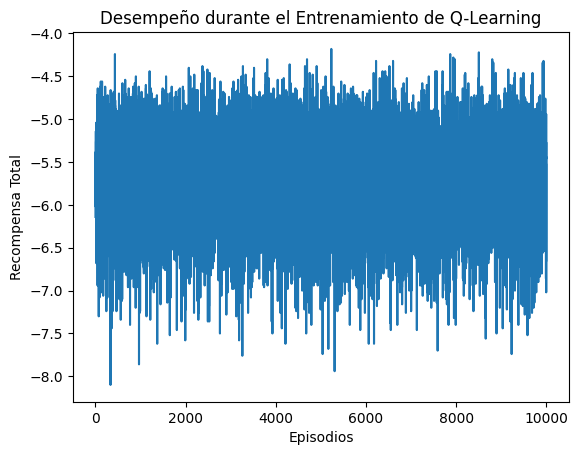

In [62]:
# Baseline always choose the same action:


# Bucle de entrenamiento
env = TrafficEnv(LAMBDA_ARRIVAL_C1, LAMBDA_ARRIVAL_C2)
rewards_per_episode = []
epsilon = EPSILON

episode_changes = [3000, 6000]

for episode in range(NUM_EPISODES):
    state = env.reset()
    total_reward = 0
    for step in range(STEPS_PER_EPISODE):
        action = random.randint(0, len(env.actions)-1) 
        next_state, reward, done = env.step(action)
        c1, c2 = state
        next_c1, next_c2 = next_state
        state = next_state
        total_reward += reward
        
    # Decaimiento de epsilon
    if epsilon > EPSILON_MIN:
        epsilon *= EPSILON_DECAY
    rewards_per_episode.append(total_reward/STEPS_PER_EPISODE)
    
    if episode % 500 == 0:
        print(f"Episode {episode}: Total reward = {total_reward/STEPS_PER_EPISODE}")
        

# Graficar el desempeño del agente durante el entrenamiento
plt.plot(rewards_per_episode)
plt.xlabel("Episodios")
plt.ylabel("Recompensa Total")
plt.title("Desempeño durante el Entrenamiento de Q-Learning")
plt.show()


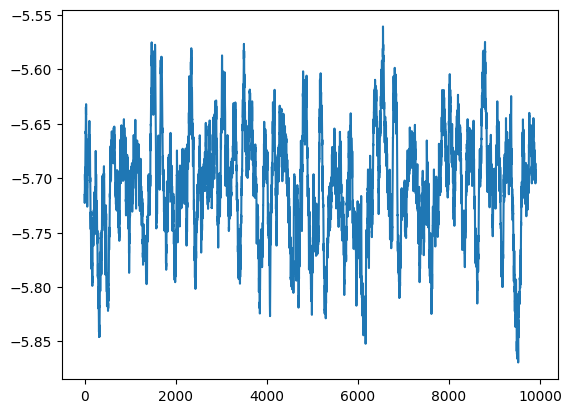

In [63]:
#plot moving average of rewards
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

plt.plot(moving_average(rewards_per_episode, 100))

## Traditional Q-learning approach (baseline)

In [64]:
# Inicialización de la tabla Q|
q_table = np.zeros((MAX_STATE + 1, MAX_STATE + 1, len(env.actions)))

def choose_action(state, epsilon):
    c1, c2 = state
    if random.random() < epsilon:
        return random.randint(0, len(env.actions)-1)  # Exploración
    else:
        return np.argmax(q_table[c1, c2, :])      # Explotación

# Bucle de entrenamiento
env = TrafficEnv(LAMBDA_ARRIVAL_C1, LAMBDA_ARRIVAL_C2)
rewards_per_episode = []
epsilon = EPSILON

episode_changes = [3000, 6000]

for episode in range(NUM_EPISODES):
    state = env.reset()
    total_reward = 0
    for step in range(STEPS_PER_EPISODE):
        action = choose_action(state, epsilon)
        next_state, reward, done = env.step(action)
        c1, c2 = state
        next_c1, next_c2 = next_state
        state = next_state
        total_reward += reward
        
        # Actualización Q-Learning (Ecuación de Bellman)
        best_next = np.max(q_table[next_c1, next_c2, :])
        q_table[c1, c2, action] += ALPHA * (reward + GAMMA * best_next - q_table[c1, c2, action])
        
    env.reset()
                
    # Decaimiento de epsilon
    if epsilon > EPSILON_MIN:
        epsilon *= EPSILON_DECAY
    rewards_per_episode.append(total_reward/STEPS_PER_EPISODE)
    
    if episode % 500 == 0:
        print(f"Episode {episode}: Total reward = {total_reward/STEPS_PER_EPISODE}")
        
    if episode in episode_changes:
        if episode == 3000:
            env.c1_lambda = 1
            env.c2_lambda = 2
        elif episode == 6000:
            env.c1_lambda = 2
            env.c2_lambda = 1
        
np.mean(rewards_per_episode), np.std(rewards_per_episode), np.max(rewards_per_episode), np.min(rewards_per_episode)

Episode 0: Total reward = -6.3
Episode 500: Total reward = -5.28
Episode 1000: Total reward = -4.72
Episode 1500: Total reward = -5.28
Episode 2000: Total reward = -4.82
Episode 2500: Total reward = -4.84
Episode 3000: Total reward = -4.78
Episode 3500: Total reward = -4.48
Episode 4000: Total reward = -4.62
Episode 4500: Total reward = -4.24
Episode 5000: Total reward = -3.78
Episode 5500: Total reward = -4.14
Episode 6000: Total reward = -3.74
Episode 6500: Total reward = -4.92
Episode 7000: Total reward = -4.76
Episode 7500: Total reward = -4.98
Episode 8000: Total reward = -4.98
Episode 8500: Total reward = -5.06
Episode 9000: Total reward = -5.22
Episode 9500: Total reward = -5.04
Episode 10000: Total reward = -5.18


(-4.90016598340166, 0.5359097802032573, -3.14, -7.42)

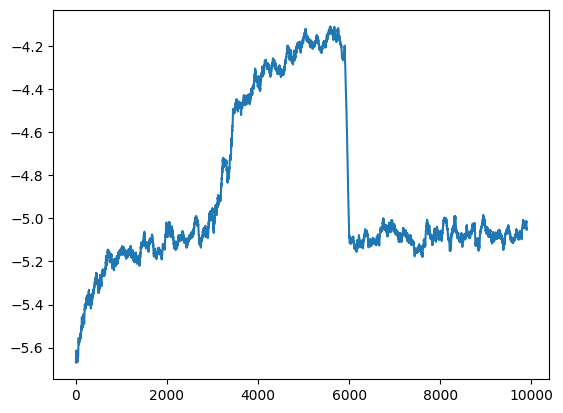

In [65]:
plt.plot(moving_average(rewards_per_episode, 100))

## Adaptive Agent

In [66]:
class PageHinkley:
    def __init__(self, delta=0.01, threshold=300.0):
        """
        Parámetros:
          - delta: un pequeño valor (bias) que evita detectar cambios por fluctuaciones menores.
          - threshold: umbral que, al ser superado, indica que se ha detectado un cambio.
        """
        self.delta = delta
        self.threshold = threshold
        self.reset()

    def reset(self):
        """Reinicia los acumulados y contadores del test."""
        self.mean = 0.0
        self.cumulative_sum = 0.0
        self.min_cumulative_sum = 0.0
        self.n = 0

    def update(self, x):
        """
        Actualiza el PH-Test con el valor x (en este caso, la recompensa acumulada del episodio)
        y retorna True si se detecta un cambio.
        """
        self.n += 1
        # Actualización incremental de la media
        self.mean = self.mean + (x - self.mean) / self.n
        # Se acumula la diferencia entre el valor actual, la media y el delta
        self.cumulative_sum += (self.mean - x - self.delta)
        # Se guarda el mínimo acumulado
        self.min_cumulative_sum = min(self.min_cumulative_sum, self.cumulative_sum)
        # Si la diferencia acumulada (desde el mínimo) supera el umbral, se detecta un cambio
        
        if (self.cumulative_sum - self.min_cumulative_sum) > self.threshold:
            return True
        else:
            return False


In [67]:
class AdaptativeAgent():
    def __init__(
        self,
        initial_state: Tuple[int, int],
        actions: list,
        n_rows: int,
        n_cols: int,
        alpha: float = 0.1,    # Tasa de aprendizaje base
        gamma: float = 0.9,    # Factor de descuento
        min_epsilon: float = 0.1,
        decay_rate: float = 0.003,
        alpha_max: float = 0.99,  # Tasa de aprendizaje máxima en caso de gran error
        td_threshold: float = 0.1,  # Umbral para activar adaptación
    ):
        # Parámetros de Q-learning
        self.alpha = alpha              # Tasa base
        self.gamma = gamma
        self.min_epsilon = min_epsilon
        self.decay_rate = decay_rate
        self.alpha_max = alpha_max
        self.td_threshold = td_threshold
        self.effective_alpha = alpha
        
        # Configuración del entorno
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.actions = actions
        
        # Estado inicial
        self.initial_state = initial_state
        self.current_state = initial_state
        
        # Q-table (diccionario de diccionarios)
        self.q_knowledge = np.zeros((len(self.actions), self.n_rows, self.n_cols))
        
        # Contadores
        self.steps = 0
        
        # Aux
        self.map_ix_action = {i: a for i, a in enumerate(self.actions)}  
        self.map_action_ix = {a: i for i, a in enumerate(self.actions)}      
        
    
    def update_actions(self, actions: dict) -> None:
        """Actualiza las acciones disponibles"""
        # Reconfigura la Q-table agregando (append) nuevas acciones sobre la q_knowledge original
        if len(self.actions) < len(actions):
            new_actions = len(actions) - len(self.actions)
            self.q_knowledge = np.append(
                                        self.q_knowledge, 
                                        np.zeros((new_actions, 
                                                self.n_rows, self.n_cols)), 
                                        axis=0)
            
        self.actions = actions
        self.map_ix_action = {i: a for i, a in enumerate(self.actions)}  
        self.map_action_ix = {a: i for i, a in enumerate(self.actions)}
    
    
    def get_best_action(self, state: Tuple[int, int]) -> Tuple[str, float]:
        """Selecciona la mejor acción usando explotación"""
        action = np.argmax(self.q_knowledge[:, state[0], state[1]])
        action = self.map_ix_action[action]
        q_value = np.max(self.q_knowledge[:, state[0], state[1]])
        return action, q_value
    
    def update_q_value(
        self,
        current_state: Tuple[int, int],
        action: str,
        reward: float,
        next_state: Tuple[int, int]
    ) -> float:
        """
        Actualiza la Q-table usando una tasa de aprendizaje adaptativa que 
        fusiona el conocimiento previo con la nueva información.
        """
        action = self.map_action_ix[action]
        current_q = self.q_knowledge[action][current_state]
        # Obtener la mejor acción en el siguiente estado
        _, next_max_q = self.get_best_action(next_state)
        
        # Calcular el TD error
        td_error = reward + self.gamma * next_max_q - current_q
        
        # Función sigmoide para ajustar la tasa de aprendizaje:
        activation = 1.0 / (1.0 + np.exp(-(abs(td_error) - self.td_threshold)))
        effective_alpha = self.alpha + (self.alpha_max - self.alpha) * activation
        
        # Actualizar la Q-table de forma "fuzzy":
        self.effective_alpha = effective_alpha
        new_q = current_q + self.effective_alpha * td_error            
        
        self.q_knowledge[action][current_state] = new_q
        
        
        return new_q
    
    def choose_action(self, epsilon: float) -> str:
        """Selección de acción epsilon-greedy"""
        if random.random() < epsilon:
            return random.choice(self.actions)
        # Explotación
        best_action, _ = self.get_best_action(self.current_state)
        return best_action
    
    def epsilon_decay(self, step: int) -> float:
        """Decaimiento exponencial de epsilon"""
        return self.min_epsilon + (1 - self.min_epsilon) * np.exp(-self.decay_rate * step)
    
    
    def restart(self) -> None:
        """Reinicia el agente a su estado inicial sin borrar la Q-table (se conserva el conocimiento)"""
        self.current_state = self.initial_state
        self.steps = 0
        
    def __str__(self) -> str:
        return f"AdaptativeAgent at {self.current_state} with Q-values {self.q_knowledge[self.current_state]}"


In [92]:
# Inicialización del entorno y parámetros
N_ROWS = MAX_STATE + 1
N_COLS = MAX_STATE + 1

EXPLOTATION = 0.2

# Inicialización del agente
agent = AdaptativeAgent(
    initial_state=(4, 4),
    actions=[0,1,2],
    n_rows=N_ROWS,
    n_cols=N_COLS,
    decay_rate=.002, # más grande => más errático
    alpha=0.01,
    alpha_max=0.2,
    td_threshold=5, # más pequeño => más sensible
    min_epsilon=EPSILON_MIN,
)

# alpha y epsilon deben ser directamente proporcionales

# Inicialización del Page-Hinkley Test
ph_test = PageHinkley(delta=0.5, threshold=3)

# Variables para el seguimiento del entrenamiento
learning_curve = []
exploration_curve = []

change_detection = []

alpha_evol = []
episode = 0
e = 0     # Contador para la función de decaimiento de epsilon


q_learning_acc = 0.0


outlier_reward = None

env = TrafficEnv(c1_lambda=LAMBDA_ARRIVAL_C1, c2_lambda=LAMBDA_ARRIVAL_C2)
rewards_per_episode = []

episode_changes = [3000, 6000]

c1_h = []
c2_h = []

# Bucle de entrenamiento
for episode in range(NUM_EPISODES):
    state = env.reset()
    total_reward = 0
    for step in range(STEPS_PER_EPISODE):
        # Selecciona la acción usando epsilon adaptativo
        adaptive_epsilon = agent.epsilon_decay(step=e)
        action = agent.choose_action(adaptive_epsilon)
        next_state, reward, done = env.step(action)
        c1, c2 = state
        c1_h.append(c1)
        c2_h.append(c2)
        next_c1, next_c2 = next_state
        # Actualiza el estado actual del agente
        agent.current_state = next_state
        state = next_state
        # Acumula la recompensa del episodio
        total_reward += reward
        
        # Actualiza la Q-table usando la función de actualización
        new_q = agent.update_q_value(
            current_state=(c1, c2),
            action=action,
            reward=reward,
            next_state=(next_c1, next_c2)
        )

        # Realiza el movimiento y actualiza la Q-table
        q_learning_acc += new_q

        # Actualiza métricas (por ejemplo, para visualización)
        exploration_curve.append([adaptive_epsilon, new_q])
        alpha_evol.append(agent.effective_alpha)
        
        #print(f"({episode},{step}) --- alpha", agent.effective_alpha, "--- epsilon", adaptive_epsilon)
        
    # Finaliza el episodio si se alcanza un objetivo o se excede un límite de pasos
    env.reset()
    
    e += 1

    episode += 1
            
    # Registra la recompensa media del episodio (puedes ajustar la métrica que prefieras)
    
    total_reward /= STEPS_PER_EPISODE
    if ph_test.update(total_reward):
        outlier_reward = total_reward
        e *= 0.5
        print(f"Cambio detectado en episodio {episode} con recompensa {total_reward}", e)
        change_detection.append(episode)
        ph_test.reset()
        
        #if agent.actions == [0, 1, 2]:
        #    actions = {**actions,
        #                3: {'C1_reduction': 10, 'C2_reduction': 10},
        #                4: {'C1_reduction': 10, 'C2_reduction': 10}
        #                }
        #    agent.update_actions([0, 1, 2, 3, 4])
            
    if episode % 500 == 0:
        print(f"Episode {episode}: Total reward = {total_reward}") 
    
        
    if episode in episode_changes:
        if episode == 3000:
            env.c1_lambda = 2
            env.c2_lambda = 4
        elif episode == 6000:
            env.c1_lambda = 2
            env.c2_lambda = 1
        
    rewards_per_episode.append(total_reward)
    
np.mean(rewards_per_episode), np.std(rewards_per_episode), np.max(rewards_per_episode), np.min(rewards_per_episode)

Episode 500: Total reward = -5.08
Episode 1000: Total reward = -4.62
Episode 1500: Total reward = -6.36
Episode 2000: Total reward = -5.42
Episode 2500: Total reward = -4.88
Episode 3000: Total reward = -4.84
Cambio detectado en episodio 3001 con recompensa -13.46 1500.5
Episode 3500: Total reward = -12.16
Episode 4000: Total reward = -10.84
Episode 4500: Total reward = -9.4
Episode 5000: Total reward = -9.72
Episode 5500: Total reward = -9.94
Episode 6000: Total reward = -10.14
Episode 6500: Total reward = -5.74
Episode 7000: Total reward = -5.32
Episode 7500: Total reward = -5.4
Episode 8000: Total reward = -4.92
Episode 8500: Total reward = -6.36
Episode 9000: Total reward = -4.88
Episode 9500: Total reward = -4.92
Episode 10000: Total reward = -4.72


(-6.822229777022297, 2.524603989751013, -3.92, -13.76)

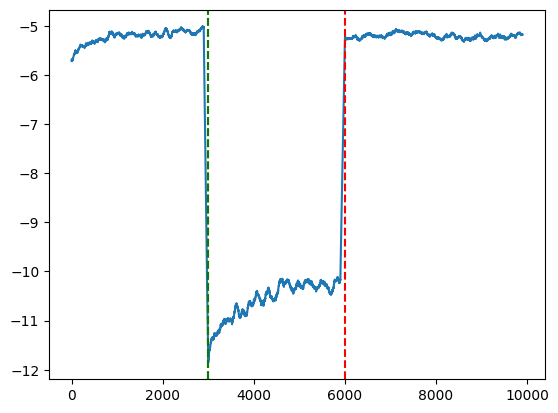

In [93]:
plt.plot(moving_average(rewards_per_episode, 100))
for v in episode_changes:
    plt.axvline(x=v, color='r', linestyle='--')
for c in change_detection:
    plt.axvline(x=c, color='g', linestyle='--')

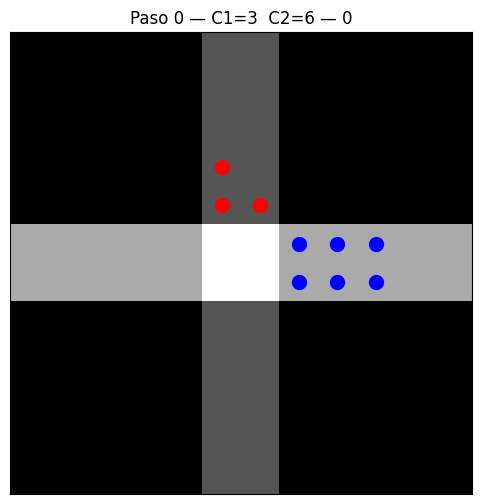

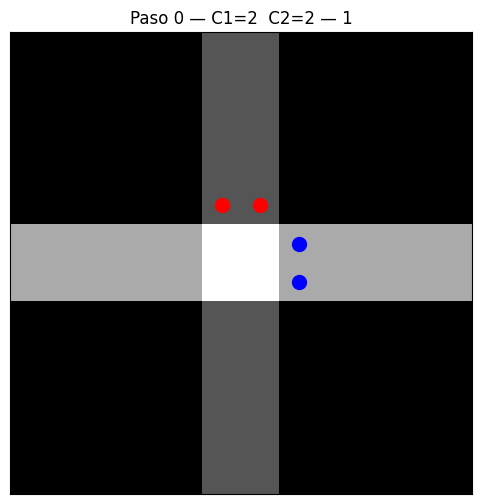

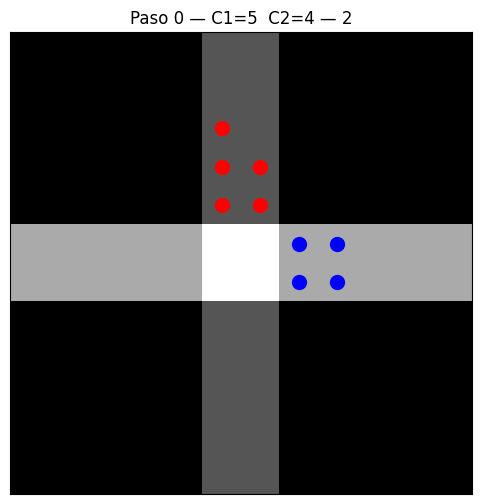

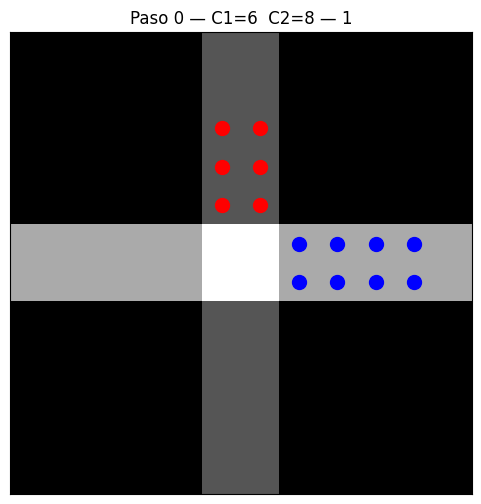

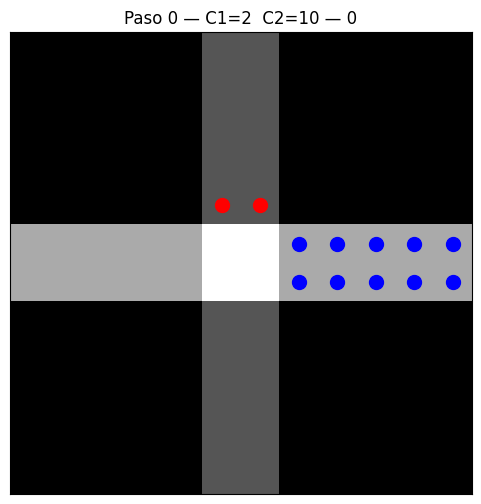

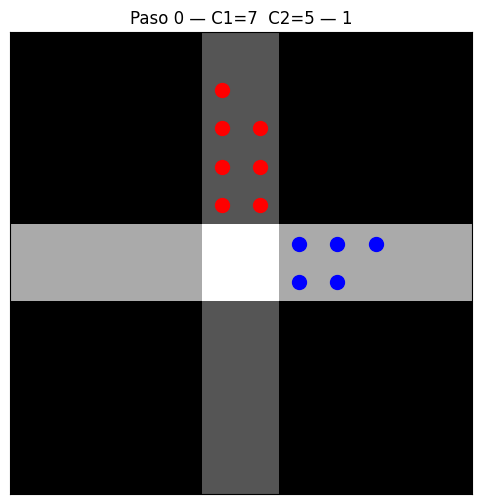

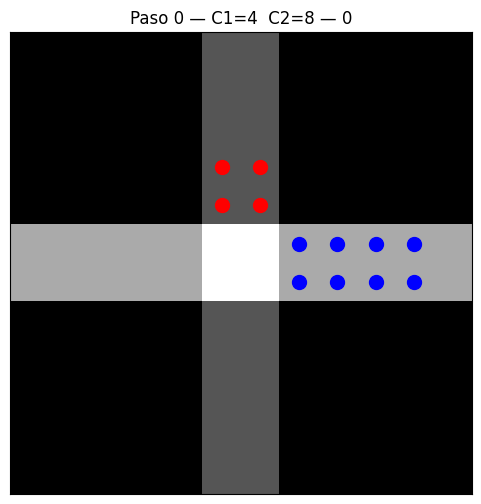

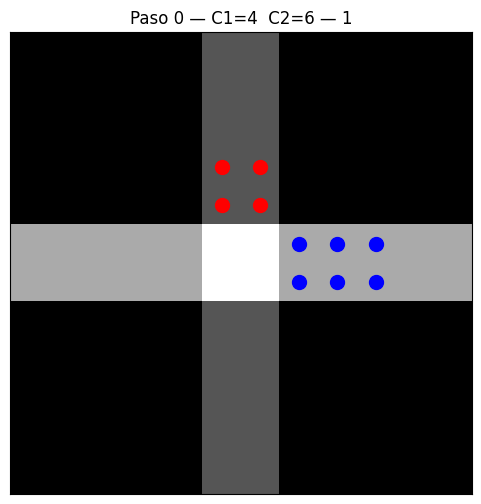

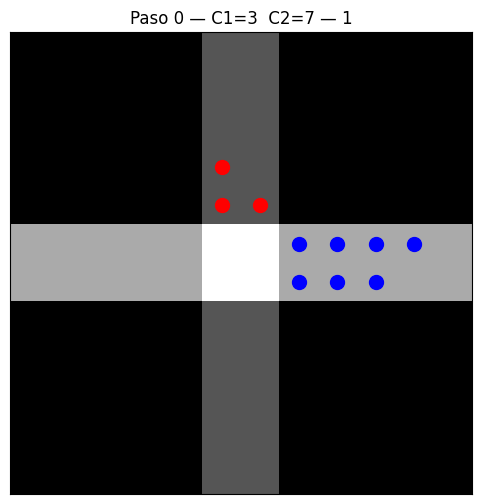

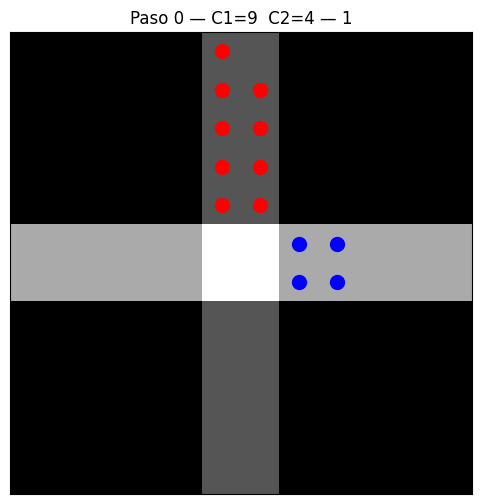

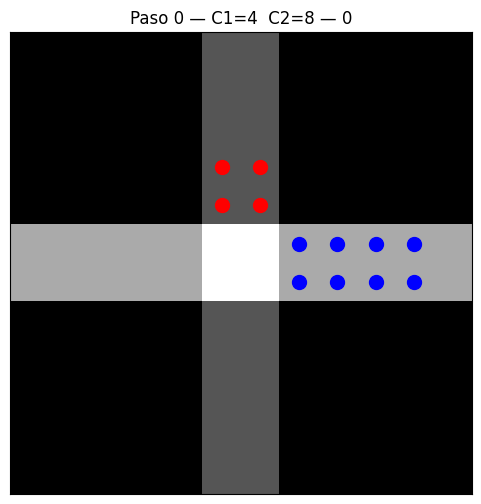

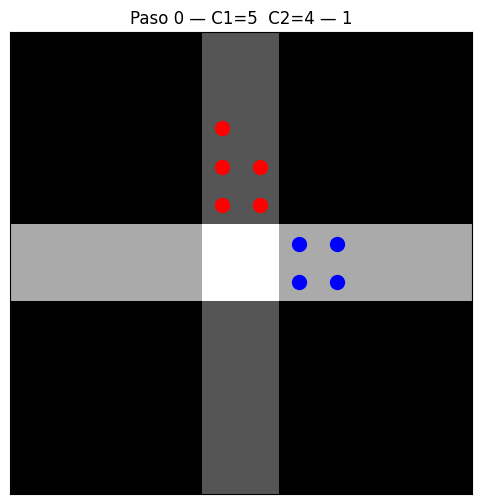

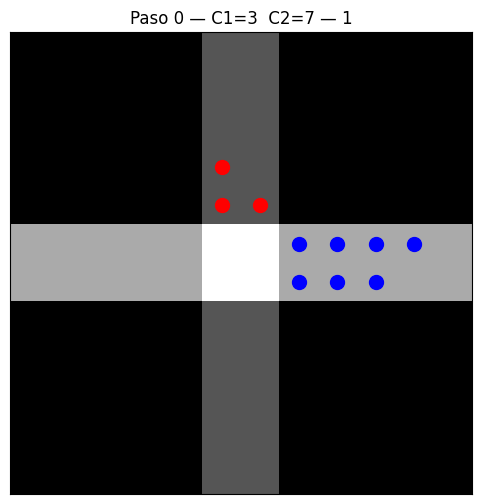

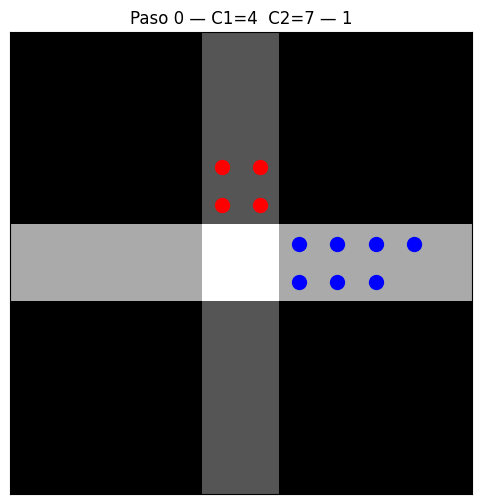

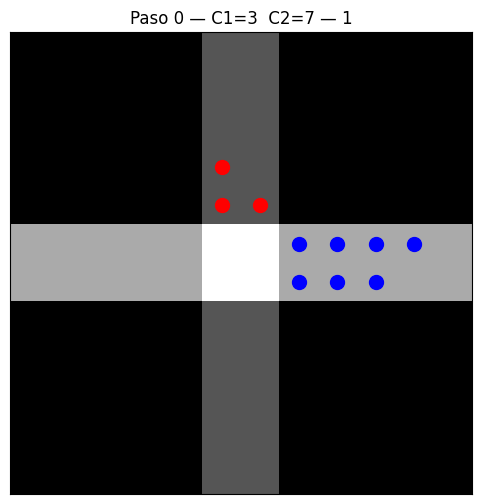

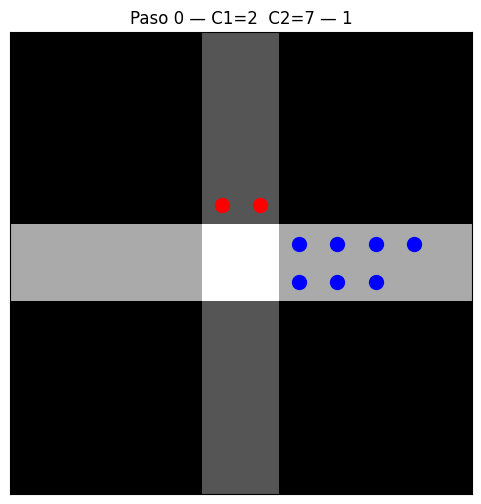

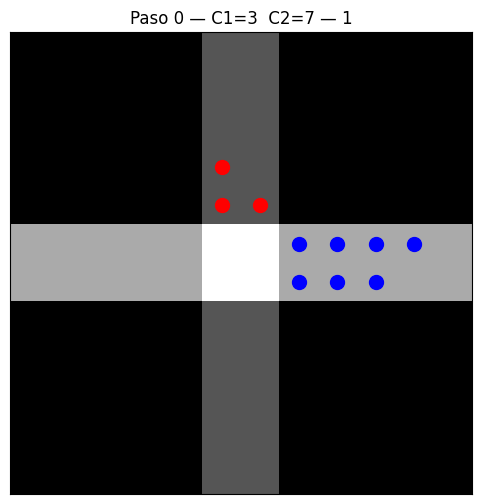

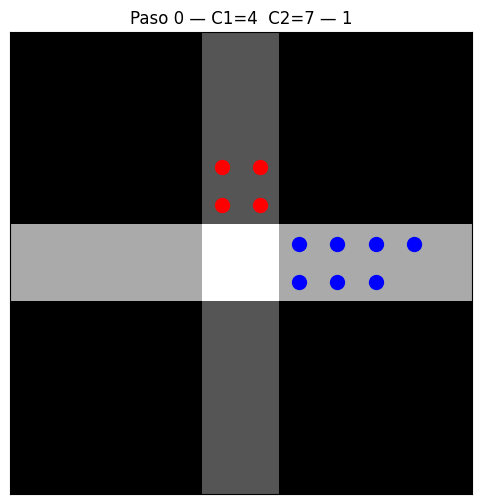

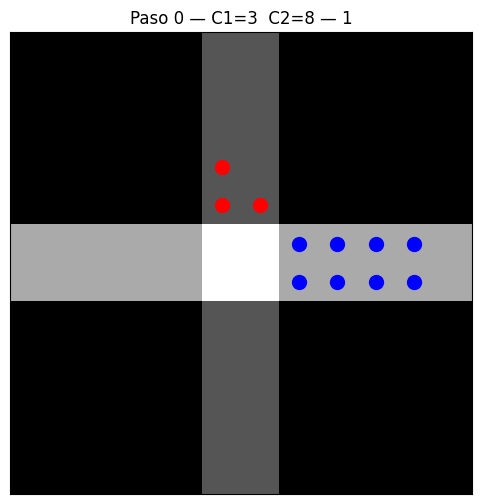

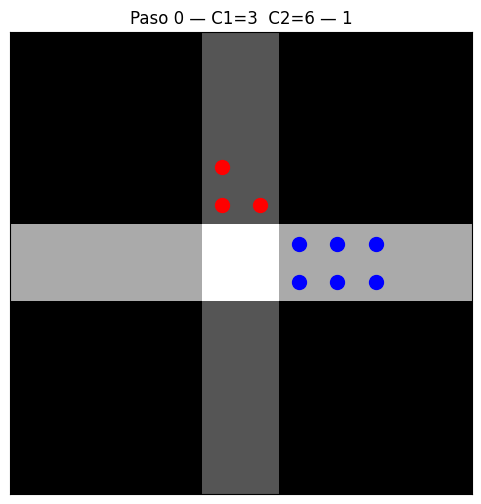

In [95]:
# simulate agent:

env = TrafficEnv(c1_lambda=2, c2_lambda=4)
state = env.reset()
for _ in range(20):
    action = agent.get_best_action(state)[0]
    state, reward, done = env.step(action)
    env.render(title=f" — {agent.map_ix_action[action]}")

(0.0, 100.0)

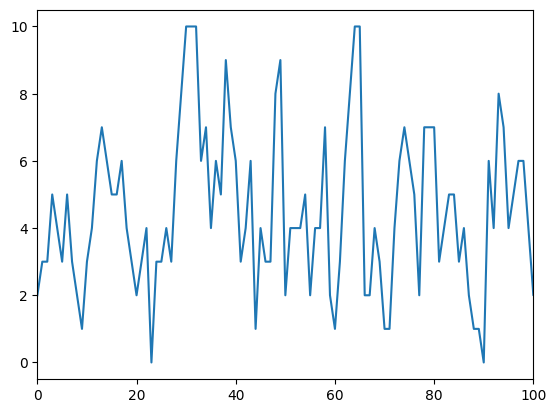

In [70]:
plt.plot(c1_h, label="C1")
plt.xlim(0, 100)

(0.0, 100.0)

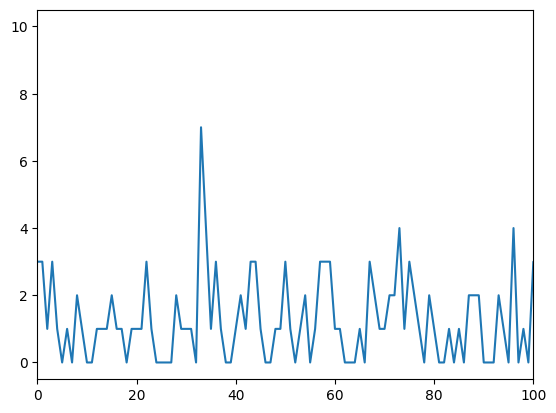

In [71]:
plt.plot(c2_h, label="C2")
plt.xlim(0, 100)

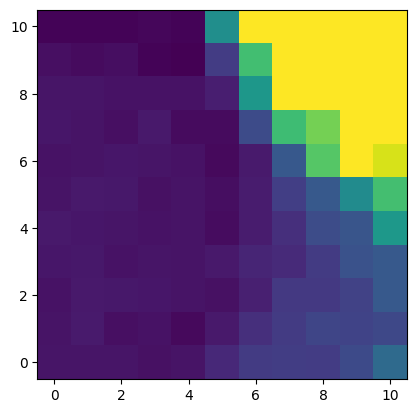

In [72]:
plt.imshow(np.max(agent.q_knowledge, axis=0), origin='lower')

In [73]:
q_table.shape

(11, 11, 3)